Korelacja ADM vs SOY: 0.722
Korelacja BG  vs SOY: 0.348

Największe odchylenia ADM (top 5% |reszt|):
Date
2022-11-22    22.916851
2022-10-31    22.872809
2022-11-25    22.389504
2022-11-01    22.148836
2022-11-23    21.827680
2022-10-28    21.765231
2021-01-12   -21.462794
2022-11-03    21.384415
2022-10-27    21.310841
2022-11-21    21.176918
dtype: float64

Największe odchylenia BG (top 5% |reszt|):
Date
2020-09-23   -37.540187
2020-09-24   -37.182787
2020-09-30   -36.851823
2020-09-21   -36.800151
2020-10-01   -36.746156
2020-09-29   -36.539365
2020-09-22   -36.510582
2020-09-11   -36.450051
2020-09-14   -36.260226
2020-10-02   -36.174849
dtype: float64


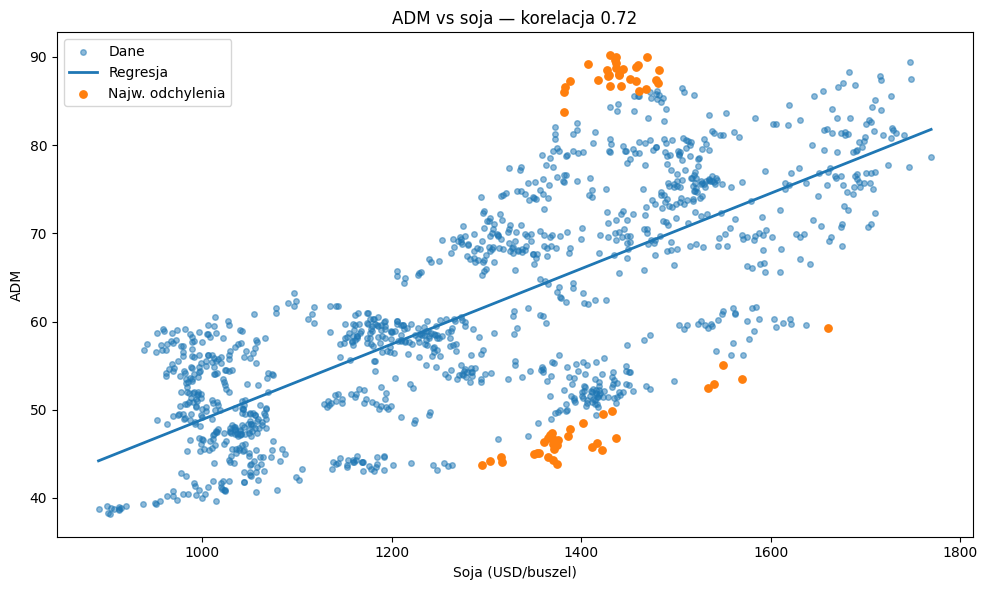

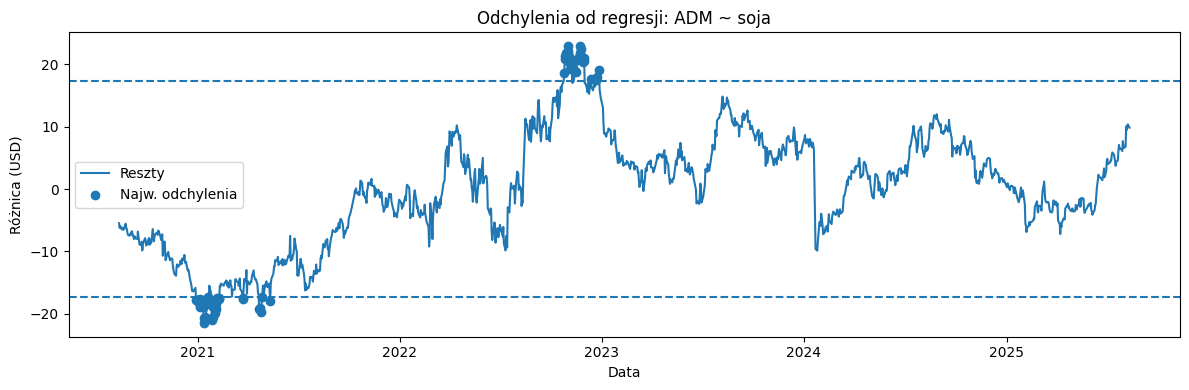

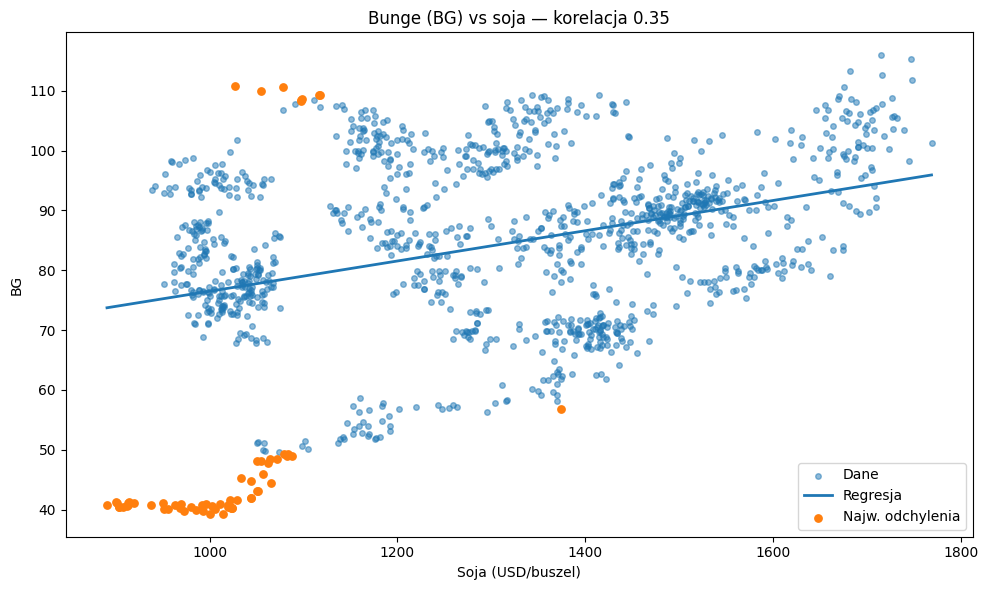

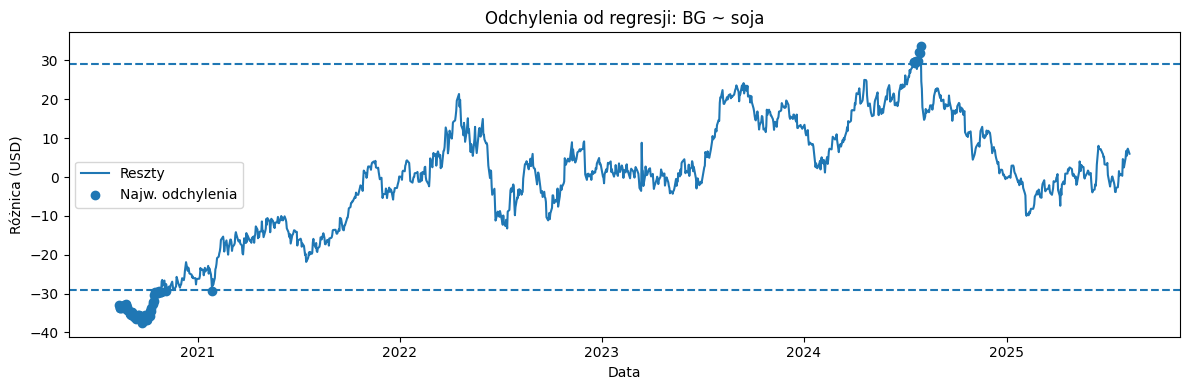

In [7]:
# -*- coding: utf-8 -*-
# pip install yfinance scikit-learn pandas numpy matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

# =========================
# 1) Pobieranie danych 5y (ADM, BG, soja)
# =========================
tickers = ["ADM", "BG", "ZS=F"]
raw = yf.download(tickers, period="5y", auto_adjust=True, progress=False)

# yfinance dla wielu tickerów zwraca MultiIndex kolumn (OHLC)
# Bierzemy Close i porządkujemy nazwy
if isinstance(raw.columns, pd.MultiIndex):
    close = raw["Close"].copy()
else:
    # asekuracyjnie, gdyby zwrócił pojedyncze kolumny
    close = raw[["Close"]].copy()
    close.columns = [tickers[0]]

close = close.rename(columns={"ZS=F": "SOY"})
close = close.dropna(how="all")

# Weryfikacja, czy mamy komplet kolumn
needed = {"ADM", "BG", "SOY"}
missing = needed - set(close.columns)
if missing:
    raise ValueError(f"Brakuje kolumn: {missing}. Sprawdź tickery/połączenie z Yahoo.")

# Wspólny dataframe do analiz (bez braków)
df = close[["ADM", "BG", "SOY"]].dropna()

# =========================
# 2) Funkcje: regresja, reszty, podświetlanie odchyleń
# =========================
def fit_regression(y: pd.Series, x: pd.Series):
    """Dopasuj y ~ a*x + b i zwróć: model, pred, resid, corr"""
    X = x.values.reshape(-1, 1)
    Y = y.values
    model = LinearRegression().fit(X, Y)
    pred = model.predict(X)
    resid = Y - pred
    corr = pd.Series(y).corr(pd.Series(x))
    return model, pd.Series(pred, index=y.index), pd.Series(resid, index=y.index), corr

def big_deviation_mask(residuals: pd.Series, q: float = 0.95):
    """Zwróć maskę największych odchyleń i próg (percentyl |resid|)."""
    thr = np.quantile(np.abs(residuals.dropna()), q)
    return np.abs(residuals) >= thr, thr

def scatter_with_regression(x: pd.Series, y: pd.Series, model: LinearRegression,
                            highlight_mask: pd.Series, title: str):
    """Scatter y vs x + linia regresji + podświetlenie outlierów."""
    plt.figure(figsize=(10, 6))
    # punkty
    plt.scatter(x, y, alpha=0.5, s=16, label="Dane")
    # linia regresji narysowana po posortowanym x
    order = np.argsort(x.values)
    x_sorted = x.values[order].reshape(-1, 1)
    y_line = model.predict(x_sorted)
    plt.plot(x_sorted, y_line, linewidth=2, label="Regresja")
    # podświetlenie największych odchyleń
    plt.scatter(x[highlight_mask], y[highlight_mask], s=28, label="Najw. odchylenia")
    plt.xlabel("Soja (USD/buszel)")
    plt.ylabel(y.name)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def residuals_in_time(residuals: pd.Series, thr: float, title: str):
    """Wykres reszt w czasie + progi ±thr i wskazanie outlierów."""
    mask = np.abs(residuals) >= thr
    plt.figure(figsize=(12, 4))
    plt.plot(residuals.index, residuals.values, label="Reszty")
    plt.axhline(thr, linestyle="--")
    plt.axhline(-thr, linestyle="--")
    plt.scatter(residuals[mask].index, residuals[mask].values, label="Najw. odchylenia")
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Różnica (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# 3) ADM ~ SOY oraz BG ~ SOY
# =========================
adm_model, adm_pred, adm_resid, adm_corr = fit_regression(df["ADM"], df["SOY"])
bg_model,  bg_pred,  bg_resid,  bg_corr  = fit_regression(df["BG"],  df["SOY"])

adm_mask, adm_thr = big_deviation_mask(adm_resid, 0.95)
bg_mask,  bg_thr  = big_deviation_mask(bg_resid,  0.95)

print(f"Korelacja ADM vs SOY: {adm_corr:.3f}")
print(f"Korelacja BG  vs SOY: {bg_corr:.3f}")

print("\nNajwiększe odchylenia ADM (top 5% |reszt|):")
print(adm_resid[adm_mask].sort_values(key=np.abs, ascending=False).head(10))

print("\nNajwiększe odchylenia BG (top 5% |reszt|):")
print(bg_resid[bg_mask].sort_values(key=np.abs, ascending=False).head(10))

# Wykresy: scatter + linia regresji + highlight
scatter_with_regression(df["SOY"], df["ADM"], adm_model, adm_mask,
                        f"ADM vs soja — korelacja {adm_corr:.2f}")
residuals_in_time(adm_resid, adm_thr, "Odchylenia od regresji: ADM ~ soja")

scatter_with_regression(df["SOY"], df["BG"], bg_model, bg_mask,
                        f"Bunge (BG) vs soja — korelacja {bg_corr:.2f}")
residuals_in_time(bg_resid, bg_thr, "Odchylenia od regresji: BG ~ soja")

# =========================================================
# 4) Indeks pogodowy soi (0–100) z temperatury i opadów
# =========================================================
# Założenia (uproszczone, prak


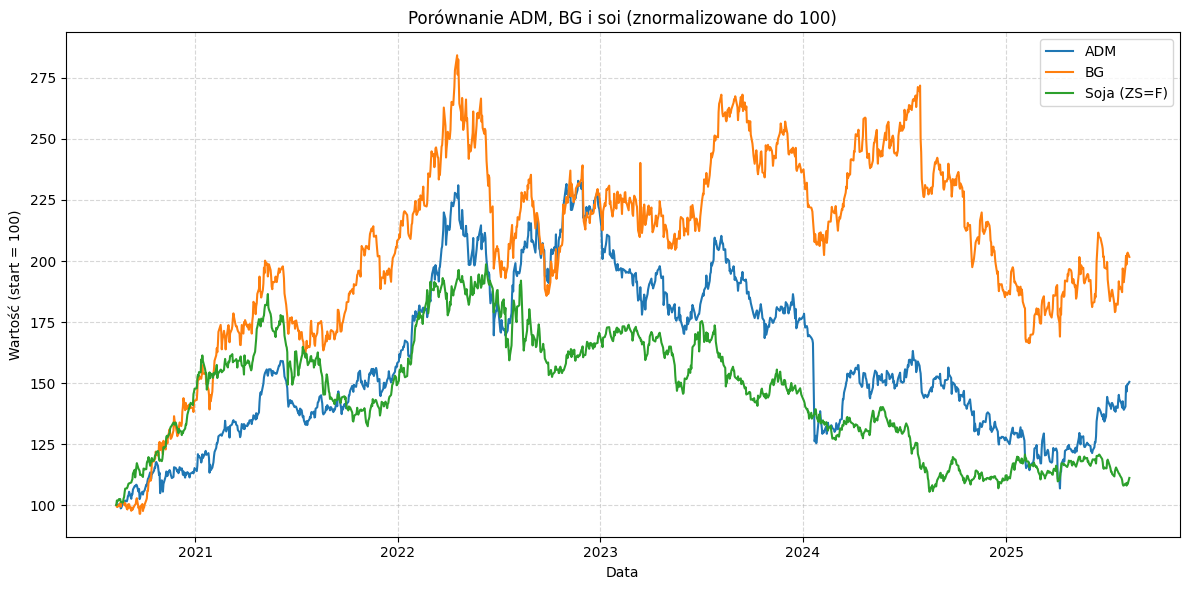

In [8]:
# ---------- Wykres porównawczy trzech serii w czasie ----------
plt.figure(figsize=(12,6))

# Normalizacja: każda seria startuje od 100
norm_df = df / df.iloc[0] * 100
plt.plot(norm_df.index, norm_df["ADM"], label="ADM")
plt.plot(norm_df.index, norm_df["BG"],  label="BG")
plt.plot(norm_df.index, norm_df["SOY"], label="Soja (ZS=F)")

plt.title("Porównanie ADM, BG i soi (znormalizowane do 100)")
plt.ylabel("Wartość (start = 100)")
plt.xlabel("Data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
